In [1]:
from typing import Dict, Iterable, Optional

import numpy as np
import torch
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
from complementary_models import HALOVICAT2 as HALOVICAT
from complementary_models import HALOVAECAT2 as HALOVAECAT
import scanpy as sc
import scvi
import pandas as pd
torch.autograd.set_detect_anomaly(True) 


Global seed set to 0


In [2]:
## load the data
adata_multi = sc.read_h5ad("halo/E18_mouse_Brain/multiomic.h5ad")
adata_multi.obs["batch_id"] = 1
adata_multi.var["modality"] =adata_multi.var["feature_types"]
adata_mvi = scvi.data.organize_multiome_anndatas(adata_multi)
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))
df_meta= pd.read_csv("halo/E18_mouse_Brain/RNA/metadata.tsv",sep = "\t",index_col=0)
df_meta

,n_counts,celltype,velo_s_norm_self_transition,root_cells,end_points,velo_s_norm_pseudotime,latent_time,binned
AAACAGCCAACCGCCA-1,681.0,Upper Layer,0.057197,0.037962,0.086987,0.857504,0.604954,"(0.6, 0.65]"
AAACAGCCAAGGTCGA-1,296.0,"RG, Astro, OPC",0.114116,0.049274,0.396248,0.213945,0.281341,"(0.25, 0.3]"
AAACAGCCAGGAACAT-1,504.0,Deeper Layer,0.082940,0.020133,0.338813,0.958743,0.851495,"(0.85, 0.9]"
AAACAGCCATATTGAC-1,321.0,Deeper Layer,0.106146,0.003566,0.735495,0.981135,0.982605,"(0.95, 1.0]"
AAACAGCCATGGTTAT-1,432.0,Subplate,0.103904,0.036739,0.134693,0.848509,0.549869,"(0.5, 0.55]"
...,...,...,...,...,...,...,...,...
TTTGTGGCATAATCGT-1,1248.0,Ependymal cells,0.089063,0.556196,0.005403,0.889134,0.454965,"(0.45, 0.5]"
TTTGTGGCATTTGCTC-1,451.0,Upper Layer,0.049716,0.013520,0.407998,0.861768,0.598991,"(0.55, 0.6]"
TTTGTGTTCAATGACC-1,369.0,IPC,0.130270,0.499946,0.019731,0.604746,0.291581,"(0.25, 0.3]"
TTTGTTGGTGGAGCAA-1,513.0,Deeper Layer,0.038342,0.062265,0.113687,0.948574,0.776289,"(0.75, 0.8]"


In [3]:
## Merge Data
bins = df_meta.binned.unique()
times = {}
index = 0
for bin in sorted(bins):
    times[bin] = index
    index += 1

def add_time(row, times):
    timestamp = times[row.binned]
    return timestamp

df_meta['time_key'] = df_meta.apply(lambda row: add_time(row, times), axis=1)

newindex = []

for idx, row in df_meta.iterrows():
    newindex.append(idx+"_paired")

df_meta['Id'] = newindex    

df_meta_sub = df_meta[["Id", 'latent_time']]

df_meta_sub.set_index("Id", inplace=True)
adata_mvi.obs = adata_mvi.obs.join(df_meta_sub, how="inner")
adata_mvi.obs

,celltype,batch_id,modality,latent_time
AAACAGCCAACCGCCA-1_paired,Upper Layer,1,paired,0.604954
AAACAGCCAAGGTCGA-1_paired,"RG, Astro, OPC",1,paired,0.281341
AAACAGCCAGGAACAT-1_paired,Deeper Layer,1,paired,0.851495
AAACAGCCATATTGAC-1_paired,Deeper Layer,1,paired,0.982605
AAACAGCCATGGTTAT-1_paired,Subplate,1,paired,0.549869
...,...,...,...,...
TTTGTGGCATAATCGT-1_paired,Ependymal cells,1,paired,0.454965
TTTGTGGCATTTGCTC-1_paired,Upper Layer,1,paired,0.598991
TTTGTGTTCAATGACC-1_paired,IPC,1,paired,0.291581
TTTGTTGGTGGAGCAA-1_paired,Deeper Layer,1,paired,0.776289


In [4]:
HALOVICAT.setup_anndata(adata_mvi, batch_key="modality", time_key='latent_time')
mvi_p = HALOVICAT(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum(),
    alpha=0.02,
    beta_1=1e6,
    beta_2=1e7,
    beta_3=100,
    n_latent_dep=5,
    n_latent_indep=5
)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/data/_utils.py:168: UserWarning: Category 0 in adata.obs['_scvi_time_label'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


time key in registry : True
cell type key in registry: False
5


In [5]:
mvi_p.train(use_gpu=True, batch_size=512)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:385: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1/500:   0%|          | 0/500 [00:00<?, ?it/s]

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/module/_multivae.py:557: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/aten/src/ATen/native/TensorShape.cpp:2985.)
  x = torch.where(mask_expr.T, x_expr.T, x_acc.T).T


n_indep: 5 after reconstructon loss 135713.375, beta:1000000.0


RuntimeError: CUDA out of memory. Tried to allocate 30.00 MiB (GPU 0; 10.73 GiB total capacity; 7.20 GiB already allocated; 49.75 MiB free; 7.37 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [24]:
mvi_p.save("./cat_models_equal/model_stronger_alternative_3")

In [5]:
## load models of HALO
mvi_p = mvi_p.load("./cat_models_equal/model_stronger_alternative_0", adata=adata_mvi)

INFO     File ./cat_models_equal/model_stronger_alternative_0/model.pt already downloaded    


/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/data/_utils.py:168: UserWarning: Category 0 in adata.obs['_scvi_time_label'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


time key in registry : True
cell type key in registry: False
5


In [6]:
mvi_p.train(use_gpu=True, batch_size=512, max_epochs=80)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:385: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1/80:   0%|          | 0/80 [00:00<?, ?it/s]

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/module/_multivae.py:557: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/aten/src/ATen/native/TensorShape.cpp:2985.)
  x = torch.where(mask_expr.T, x_expr.T, x_acc.T).T


n_indep: 5 after reconstructon loss 25794.537109375, beta:1000000.0
n_indep: 5 after reconstructon loss 25788.875, beta:1000000.0
n_indep: 5 after reconstructon loss 25688.853515625, beta:1000000.0
n_indep: 5 after reconstructon loss 25731.00390625, beta:1000000.0
n_indep: 5 after reconstructon loss 25803.4453125, beta:1000000.0
n_indep: 5 after reconstructon loss 25703.359375, beta:1000000.0
n_indep: 5 after reconstructon loss 25468.896484375, beta:1000000.0
Epoch 2/80:   1%|▏         | 1/80 [00:03<04:52,  3.70s/it, loss=2.58e+04, v_num=1]n_indep: 5 after reconstructon loss 25752.92578125, beta:1000000.0
n_indep: 5 after reconstructon loss 25765.263671875, beta:1000000.0
n_indep: 5 after reconstructon loss 25782.62109375, beta:1000000.0
n_indep: 5 after reconstructon loss 25622.3828125, beta:1000000.0
n_indep: 5 after reconstructon loss 25746.509765625, beta:1000000.0
n_indep: 5 after reconstructon loss 25719.052734375, beta:1000000.0
n_indep: 5 after reconstructon loss 25706.81054687

In [8]:

latent_atac, latent_expr, latent_atac_dep, latent_expr_dep, latent_atac_indep, latent_expr_indep, times = mvi_p.get_latent_representation()

In [9]:
from complementary_models.infer_nonsta_dir import infer_nonsta_dir
from complementary_models import torch_infer_nonsta_dir
score1, _, _ = torch_infer_nonsta_dir(torch.tensor(latent_atac_dep).to('cuda'), torch.tensor(latent_expr_dep).to('cuda'), torch.tensor(times).to('cuda'))
score1

tensor(0.0002, device='cuda:0', dtype=torch.float64)

In [25]:
score2, _, _= torch_infer_nonsta_dir(torch.tensor(latent_expr_dep).to('cuda'), torch.tensor(latent_atac_dep).to('cuda'), torch.tensor(times).to('cuda'))
score2

/tmp/ipykernel_9657/715659028.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  score2, _, _= torch_infer_nonsta_dir(torch.tensor(latent_expr_dep).to('cuda'), torch.tensor(latent_atac_dep).to('cuda'), torch.tensor(times).to('cuda'))


tensor(0.0002, device='cuda:0', dtype=torch.float64)

In [26]:
latent_atac_indep = torch.tensor(latent_atac_indep).to('cuda')
latent_expr_indep = torch.tensor(latent_expr_indep).to('cuda')
times = torch.tensor(times).to('cuda')

score3, _, _ = torch_infer_nonsta_dir(latent_atac_indep, latent_expr_indep, times)
score3

/tmp/ipykernel_9657/4099870331.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latent_atac_indep = torch.tensor(latent_atac_indep).to('cuda')
/tmp/ipykernel_9657/4099870331.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latent_expr_indep = torch.tensor(latent_expr_indep).to('cuda')
/tmp/ipykernel_9657/4099870331.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  times = torch.tensor(times).to('cuda')


tensor(0.0002, device='cuda:0', dtype=torch.float64)

In [27]:
score4, _, _ = torch_infer_nonsta_dir(latent_expr_indep, latent_atac_indep, times)
score4

tensor(0.0002, device='cuda:0', dtype=torch.float64)

In [28]:
score3 - score4

tensor(-1.1483e-05, device='cuda:0', dtype=torch.float64)

In [14]:
from numpy.linalg import inv
import pandas as pd

X = latent_atac
Y =  latent_expr

b = inv(X.T.dot(X)).dot(X.T).dot(Y)

Yhat = X.dot(b)
Y_Residual = Yhat - Y
Y_Residual = np.sum(np.abs(Y_Residual),axis=1)

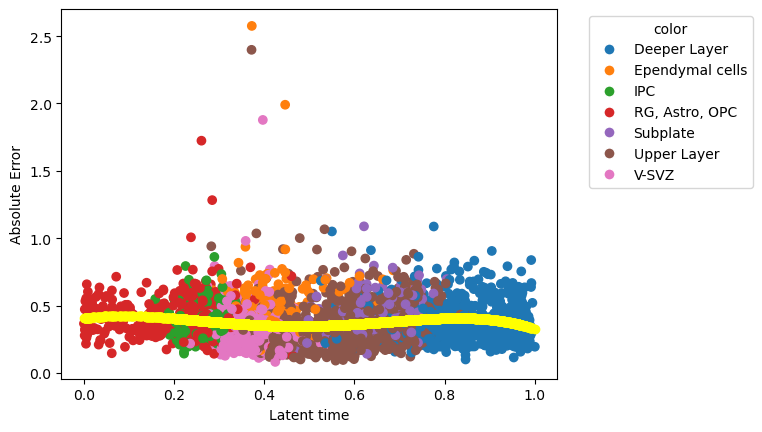

In [15]:
import tkinter
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # for legend handle


colors = {'Deeper Layer':'tab:blue', 'Ependymal cells':'tab:orange', 'IPC':'tab:green', 'RG, Astro, OPC':'tab:red', 
          'Subplate':'tab:purple', 'Upper Layer':'tab:brown', 'V-SVZ':'tab:pink'}

%matplotlib inline
plt.scatter(df_meta['latent_time'], Y_Residual, color=df_meta['celltype'].map(colors))


z = np.polyfit(df_meta['latent_time'], Y_Residual, 4)
p = np.poly1d(z)
plt.scatter(df_meta['latent_time'], p(df_meta['latent_time']),color='yellow')



handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
plt.legend(title='color', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.title('My title')
plt.xlabel('Latent time')
plt.ylabel('Absolute Error')

plt.show()

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


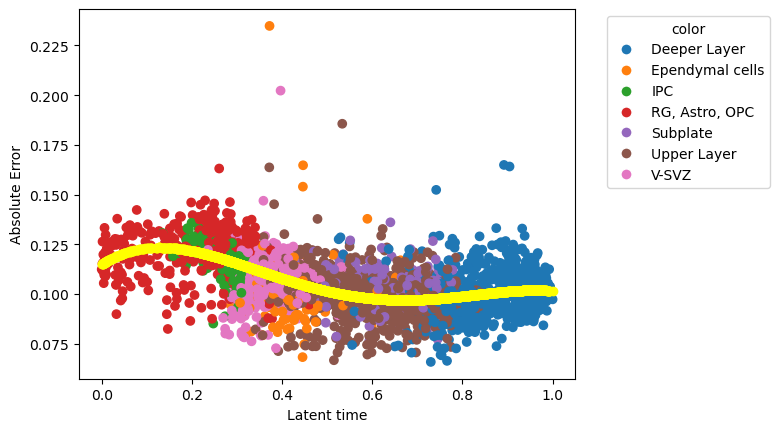

In [16]:
adata_RNA_sub  = adata_multi[:, adata_multi.var['feature_types'] == 'Gene Expression']
sc.pp.normalize_per_cell(adata_RNA_sub)
sc.pp.log1p(adata_RNA_sub)
Y = adata_RNA_sub.X.toarray()
X = latent_atac

b = inv(X.T.dot(X)).dot(X.T).dot(Y)

Yhat = X.dot(b)
Y_Residual = Yhat - Y
Y_Residual = np.mean(np.abs(Y_Residual),axis=1)


colors = {'Deeper Layer':'tab:blue', 'Ependymal cells':'tab:orange', 'IPC':'tab:green', 'RG, Astro, OPC':'tab:red', 
          'Subplate':'tab:purple', 'Upper Layer':'tab:brown', 'V-SVZ':'tab:pink'}

%matplotlib inline
plt.scatter(df_meta['latent_time'], Y_Residual, color=df_meta['celltype'].map(colors))


z = np.polyfit(df_meta['latent_time'], Y_Residual, 4)
p = np.poly1d(z)
plt.scatter(df_meta['latent_time'], p(df_meta['latent_time']),color='yellow')



handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
plt.legend(title='color', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.title('My title')
plt.xlabel('Latent time')
plt.ylabel('Absolute Error')

plt.show()

(3365, 5)


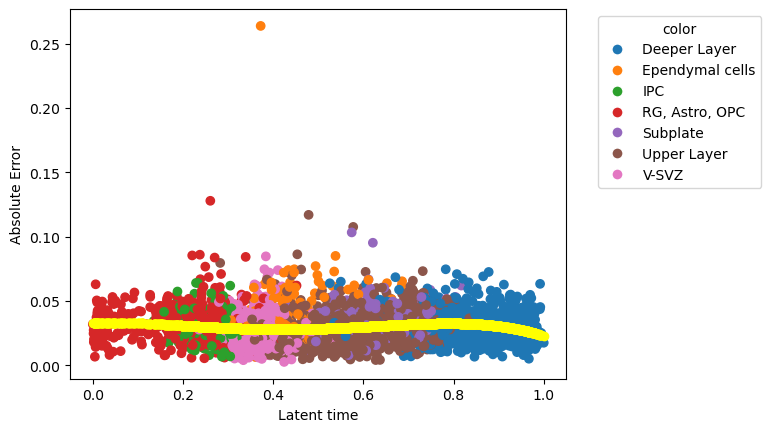

In [37]:
X = latent_atac_dep

Y =  latent_expr_dep
# Y = adata_RNA_sub.X.toarray()

print(X.shape)

b = inv(X.T.dot(X)).dot(X.T).dot(Y)

Yhat = X.dot(b)
Y_Residual = Yhat - Y
Y_Residual_dep = np.mean(np.abs(Y_Residual),axis=1)


plt.scatter(df_meta['latent_time'], Y_Residual_dep, color=df_meta['celltype'].map(colors))


z = np.polyfit(df_meta['latent_time'], Y_Residual_dep, 4)
p = np.poly1d(z)
plt.scatter(df_meta['latent_time'], p(df_meta['latent_time']),color='yellow')



handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
plt.legend(title='color', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.title('My title')
plt.xlabel('Latent time')
plt.ylabel('Absolute Error')

plt.show()

(3365, 5)
(3365, 5)


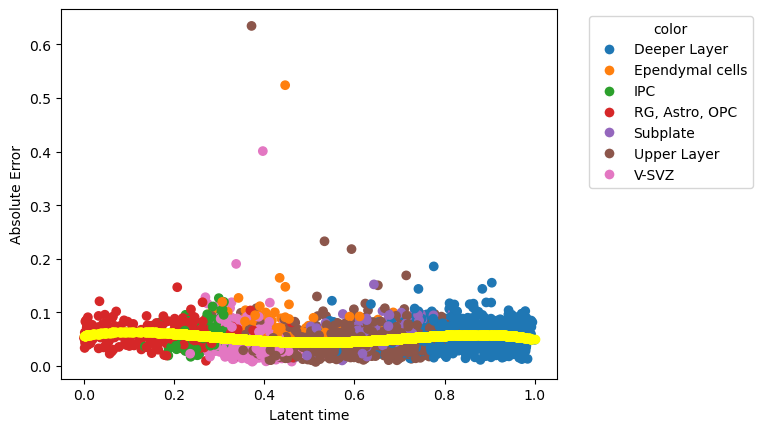

In [38]:
X = latent_atac_indep.to('cpu').detach().numpy()
Y =  latent_expr_indep.to('cpu').detach().numpy()
# Y = adata_RNA_sub.X.toarray()


print(X.shape)
print(Y.shape)


b = inv(X.T.dot(X)).dot(X.T).dot(Y)

Yhat = X.dot(b)
Y_Residual = Yhat - Y
Y_Residual = np.mean(np.abs(Y_Residual),axis=1)


plt.scatter(df_meta['latent_time'], Y_Residual, color=df_meta['celltype'].map(colors))


z = np.polyfit(df_meta['latent_time'], Y_Residual, 4)
p = np.poly1d(z)
plt.scatter(df_meta['latent_time'], p(df_meta['latent_time']),color='yellow')

# plt.scatter(df_meta['latent_time'], Y_Residual_dep, color=df_meta['celltype'].map(colors))


# z = np.polyfit(df_meta['latent_time'], Y_Residual_dep, 4)
# p = np.poly1d(z)
# plt.scatter(df_meta['latent_time'], p(df_meta['latent_time']),color='green')



handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
plt.legend(title='color', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.title('My title')
plt.xlabel('Latent time')
plt.ylabel('Absolute Error')

plt.show()